# Feature Visualization

In this notebook, we try to use t-sne method to visualize the features of images extracted from the pre-trained Inception v3 model.

In [13]:
import os
import cv2
import re
import sqlite3
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from sklearn.cluster import AgglomerativeClustering
from glob import glob
from collections import Counter
from os.path import join
from json import load, dump
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib notebook

## Sample Compounds

For visualization, we can just choose a subsample of compounds.

In [2]:
df = pd.read_csv("./data/test/meta_data/profiles/mean_well_profiles.csv")
print(df.shape)
df.head(10)

(384, 1800)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_ASSAY_WELL_ROLE,Metadata_broad_sample,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,24278,a01,24278,H-BIOA-007-3,a01,treated,BRD-K78364995-236-03-5,2.090060,DMSO,BRD-K78364995,...,3.065597,1.525995,1.596880,1.557685,1.633298,1.627728,1.618267,2.582515,2.474853,2.528092
1,24278,a02,24278,H-BIOA-007-3,a02,treated,BRD-K78414110-001-02-8,5.000000,DMSO,BRD-K78414110,...,2.947674,1.595292,1.681501,1.639656,1.438692,1.497101,1.473400,2.402188,2.443030,2.527604
2,24278,a03,24278,H-BIOA-007-3,a03,treated,BRD-K78485176-001-02-9,5.000000,DMSO,BRD-K78485176,...,2.959839,1.573649,1.641233,1.630217,1.470714,1.545823,1.499599,2.400266,2.457235,2.536708
3,24278,a04,24278,H-BIOA-007-3,a04,treated,BRD-K78496197-001-01-3,5.000000,DMSO,BRD-K78496197,...,3.323827,1.627224,1.800667,1.699291,1.419890,1.578673,1.528876,2.601877,2.439709,2.506089
4,24278,a05,24278,H-BIOA-007-3,a05,treated,BRD-K78599730-001-02-6,5.000000,DMSO,BRD-K78599730,...,3.344600,1.772216,1.913539,1.881990,1.292479,1.424874,1.378594,2.433934,2.356783,2.422295
5,24278,a06,24278,H-BIOA-007-3,a06,treated,BRD-K78612426-001-02-6,5.000000,DMSO,BRD-K78612426,...,3.499219,1.746578,1.896714,1.836252,1.604872,1.700492,1.687575,2.498050,2.398161,2.474145
6,24278,a07,24278,H-BIOA-007-3,a07,treated,BRD-K78633253-001-01-2,5.000000,DMSO,BRD-K78633253,...,3.715294,1.823429,2.092295,2.010445,1.585145,1.758397,1.675881,2.509877,2.409396,2.488828
7,24278,a08,24278,H-BIOA-007-3,a08,treated,BRD-K78637815-001-01-4,5.000000,DMSO,BRD-K78637815,...,3.360001,1.693696,1.795996,1.783097,1.587473,1.714071,1.649360,2.390896,2.383596,2.445147
8,24278,a09,24278,H-BIOA-007-3,a09,treated,BRD-K78643075-001-03-3,2.379167,DMSO,BRD-K78643075,...,3.559220,1.857709,1.973541,1.909170,1.654707,1.760128,1.705003,2.320583,2.282689,2.343038
9,24278,a10,24278,H-BIOA-007-3,a10,treated,BRD-K78692225-001-11-2,5.000000,DMSO,BRD-K78692225,...,3.543376,1.810797,1.847711,1.791665,1.531595,1.699469,1.603155,2.381528,2.369899,2.450524


In this plate, 64 wells are treated using DMSO (control group). Other wells all have different chemical compounds. We can randomly sample 3 other compounds (a15, j12 and p22).

Then we use the [python scrip](./script/image_processing.py) to crop all single cell images from those selected wells.

For each cell, we have two outputs (with RGB channels merged from channels 1, 2, 3 and channels 4, 5).


|Well|Role|Number|
|:---:|:---:|:---:|
|a13|Control|354|
|a15|Treatment|370|
|j12|Treatment|660|
|p22|Treatment|541|

In [4]:
def compute_entropy(img_name):
    """
    Compute the entropy function (like entropy() in Matlab)
    """
    
    img = cv2.imread(img_name, 0)
    cur_hist = cv2.calcHist([img],[0], None, [256], [0,256]).flatten()

    # Remove zeroes
    hist_no_zero = np.array([i for i in cur_hist if i != 0])

    # Normalize the hist so it sums to 1
    hist_no_zero = hist_no_zero / np.size(img)

    # Compute the entropy
    log_2 = np.log(hist_no_zero) / np.log(2)
    entropy = -1 * np.dot(hist_no_zero, log_2)
    return entropy
    
    
def compute_entropy_dir(input_dir):
    """ 
    Wrapper function for compute_entropy() in dir level.
    Return two lists [image_names], [entropy] with the same index.
    """
    
    images, entropies = [], []
    for image in glob(join(input_dir, "*.tif")):
        images.append(image)
        entropies.append(compute_entropy(image))

    return images, entropies

def plot_images(stack, row, column):
    """
    Plot all the images in the row matrix of images in the 
    given format. Automatically add padding to the end.
    """
    image_size = stack.shape[0]
    image = np.zeros((row*image_size, column*image_size, 3)).astype(np.uint16)
    for i in range(int(stack.shape[1]/image_size)):
        r, c = i // column, i % column
        image[image_size*r:image_size*(r+1),
              image_size*c:image_size*(c+1), :] = stack[:, image_size*i:image_size*(i+1), :]
    return image

In [5]:
# Compute and srot the entropy
a13_sorted_entropy = sorted(zip(*compute_entropy_dir("train/24278_a13/c123")), key=lambda x: x[1])
a15_sorted_entropy = sorted(zip(*compute_entropy_dir("train/24278_a15/c123")), key=lambda x: x[1])
a13_sorted_entropy_2 = sorted(zip(*compute_entropy_dir("train/24278_a13/c45")), key=lambda x: x[1])
a15_sorted_entropy_2 = sorted(zip(*compute_entropy_dir("train/24278_a15/c45")), key=lambda x: x[1])

In [6]:
# Plot the images
temp_list = []
for r in a13_sorted_entropy:
    img = cv2.imread(r[0].replace("train", "out").replace('tif', 'png'), -1)
    temp_list.append(cv2.resize(img, (100, 100)))
img_stack = np.hstack(temp_list)
img_total = plot_images(img_stack, 36, 10)
cv2.imwrite("./plots/a13_ch123.png", img_total)

temp_list = []
for r in a13_sorted_entropy_2:
    img = cv2.imread(r[0].replace("train", "out").replace('tif', 'png'), -1)
    temp_list.append(cv2.resize(img, (100, 100)))
img_stack = np.hstack(temp_list)
img_total = plot_images(img_stack, 36, 10)
cv2.imwrite("./plots/a13_ch45.png", img_total)

temp_list = []
for r in a15_sorted_entropy:
    img = cv2.imread(r[0].replace("train", "out" ).replace('tif', 'png'), -1)
    temp_list.append(cv2.resize(img, (100, 100)))
img_stack = np.hstack(temp_list)
img_total = plot_images(img_stack, 37, 10)
cv2.imwrite("./plots/a15_ch123.png", img_total)

temp_list = []
for r in a15_sorted_entropy_2:
    img = cv2.imread(r[0].replace("train", "out").replace('tif', 'png'), -1)
    temp_list.append(cv2.resize(img, (100, 100)))
img_stack = np.hstack(temp_list)
img_total = plot_images(img_stack, 37, 10)
cv2.imwrite("./plots/a15_ch45.png", img_total)

True

## Original Image of a15

<p align="center">
    <img src="./plots/a15_ch123_total.png">
    <center><em>Channel 1, 2, 3 as RGB</em></center>
</p>

<p align="center">
    <img src="./plots/a15_ch45_total.png">
    <center><em>Channel 4, 5 as RB</em></center>
</p>


## Treatment a15 channels 123
![](./plots/a15_ch123.png)

## Control a13 channels 123
![](./plots/a13_ch123.png)

## Treatment a15 channels 45
![](./plots/a15_ch45.png)

## Control a13 channels 45
![](./plots/a13_ch45.png)

We can see:
- Cell size varies within each group.
- There is no obvious morphology difference between treatment `a15` and control `a13`.

## t-SNE Plots

![](./plots/t-sne_c123.png)


![](./plots/t-sne_c45.png)

We found there is a small cluster in each t-SNE plot. Two clusters contain almost the same images.

In [7]:
# Plot the interesting cluster
cluster = ["24278_j12_5_c065.png", "24278_j12_2_c001.png", "24278_j12_3_c001.png", "24278_j12_1_c093.png", "24278_j12_1_c079.png", "24278_j12_2_c002.png", "24278_j12_1_c097.png", "24278_j12_3_c005.png", "24278_j12_6_c096.png", "24278_j12_2_c077.png", "24278_j12_3_c076.png", "24278_j12_2_c049.png", "24278_j12_6_c090.png", "24278_j12_2_c070.png", "24278_j12_6_c091.png", "24278_j12_4_c003.png", "24278_j12_6_c093.png", "24278_j12_6_c092.png", "24278_j12_2_c094.png", "24278_j12_5_c032.png", "24278_j12_1_c013.png", "24278_j12_3_c090.png", "24278_j12_3_c091.png", "24278_j12_1_c098.png", "24278_j12_6_c002.png", "24278_j12_4_c131.png", "24278_j12_6_c014.png", "24278_j12_5_c122.png", "24278_j12_6_c005.png", "24278_j12_3_c032.png", "24278_j12_6_c004.png", "24278_j12_5_c121.png", "24278_j12_5_c082.png", "24278_j12_5_c120.png", "24278_p22_2_c094.png", "24278_p22_3_c135.png", "24278_p22_4_c020.png", "24278_p22_3_c045.png", "24278_p22_2_c079.png", "24278_p22_3_c090.png", "24278_p22_6_c002.png", "24278_p22_4_c051.png", "24278_p22_5_c085.png", "24278_p22_6_c001.png", "24278_p22_5_c083.png", "24278_p22_5_c082.png", "24278_p22_2_c015.png", "24278_p22_3_c001.png", "24278_p22_3_c014.png", "24278_p22_5_c077.png", "24278_p22_4_c049.png", "24278_p22_2_c005.png", "24278_p22_1_c025.png", "24278_p22_6_c121.png", "24278_p22_6_c122.png", "24278_p22_6_c092.png", "24278_p22_5_c002.png", "24278_p22_1_c020.png", "24278_p22_2_c067.png", "24278_a13_5_c069.png", "24278_a13_3_c019.png", "24278_a13_3_c025.png", "24278_a13_5_c068.png", "24278_a13_6_c005.png", "24278_a13_3_c036.png", "24278_a13_6_c001.png", "24278_a13_3_c035.png", "24278_a13_1_c072.png", "24278_a13_6_c002.png", "24278_a13_5_c035.png", "24278_a13_1_c003.png", "24278_a13_1_c002.png", "24278_a13_3_c051.png", "24278_a13_1_c006.png", "24278_a13_1_c005.png", "24278_a13_4_c026.png", "24278_a13_5_c003.png", "24278_a13_4_c002.png", "24278_a13_2_c071.png", "24278_a13_4_c001.png", "24278_a13_5_c001.png", "24278_a13_4_c005.png", "24278_a13_3_c049.png", "24278_a13_5_c012.png", "24278_a13_2_c063.png", "24278_a13_4_c007.png", "24278_a13_2_c004.png", "24278_a13_2_c006.png", "24278_a13_3_c003.png", "24278_a13_3_c002.png", "24278_a13_6_c036.png", "24278_a13_3_c001.png", "24278_a13_2_c001.png", "24278_a15_3_c004.png", "24278_a15_3_c001.png", "24278_a15_2_c002.png", "24278_a15_3_c002.png", "24278_a15_3_c017.png", "24278_a15_4_c001.png", "24278_a15_5_c001.png", "24278_a15_1_c008.png", "24278_a15_5_c002.png", "24278_a15_1_c009.png", "24278_a15_6_c055.png", "24278_a15_4_c004.png", "24278_a15_6_c043.png", "24278_a15_6_c056.png", "24278_a15_5_c008.png", "24278_a15_1_c001.png", "24278_a15_1_c004.png", "24278_a15_1_c005.png", "24278_a15_2_c055.png", "24278_a15_5_c056.png", "24278_a15_5_c055.png", "24278_a15_6_c016.png", "24278_a15_6_c003.png"]
temp_list = []
for r in cluster:
    wid = re.sub('(\d*_.*)_\d_.*\.png', r'\1', r)
    img = cv2.imread("./out/{}/c123/{}".format(wid, r), -1)
    temp_list.append(cv2.resize(img, (100, 100)))
img_stack = np.hstack(temp_list)
img_total = plot_images(img_stack, 12, 10)
cv2.imwrite("./plots/cluster.png", img_total)

True

![](./plots/cluster.png)

The trained Inception v3 picks up the irregular shape of bounding box as a feature.

## 2. Whole Image Feature Check

Instead of cropping to single cell images. We retrain the Inception v3 model using the original full size images. Five channels are merged into two RGB images. Each gives 2048 features, so each shot gives a 4096 row vector. The whole plate gives us a matrix with dimension (2282, 4096).

There are 320 compounds used in my test plate 24278. We can plot them all together in <a href="./plots/t-sne.png">one t-SNE plot</a>.

We also can split those 320 compounds to groups, where each group has at most 30 compounds with the control DMSO. Then we can plot <a href="./plots/final.png">11 t-SNE plots. </a>

![](./plots/final.png)

### 2.1 Comments

1. This might not be the best way to do the cluster analysis. Our data is very high dimensional and with few sample size (each compounds only have 6-9 observations), which limits the choice of methods.
2. We can see some interesting clustering in the edge of dots above.

## 3. t-sne across 16 plates

The plot below is selected from t-sne plots across all 16 plates. There are 29804 rows (points) in the t-sne output with 4168 compounds. All plots share the same scale.

It needs 3.5 hours to compute the t-sne statistics. All plots are stored in `./plots/t-sne` directory.

![](./plots/t-sne/interesting.png)

### 3.1. Comments

1. We can see some plots have a small cluster on the left top with 1-3 compounds. However, in about 2-3 plots control group also gets mixed in that cluster.
2. It's worth trying to tune the perplexity of t-sne because we have too many rows.

## 4. t-SNE in 3D Space

It might be helpful to use t-SNE to reduce feature dimension to the 3D space.

In [28]:
data = load(open("./resource/24277.json", 'r'))

In [89]:
sub_data = data[0]

<IPython.core.display.Javascript object>


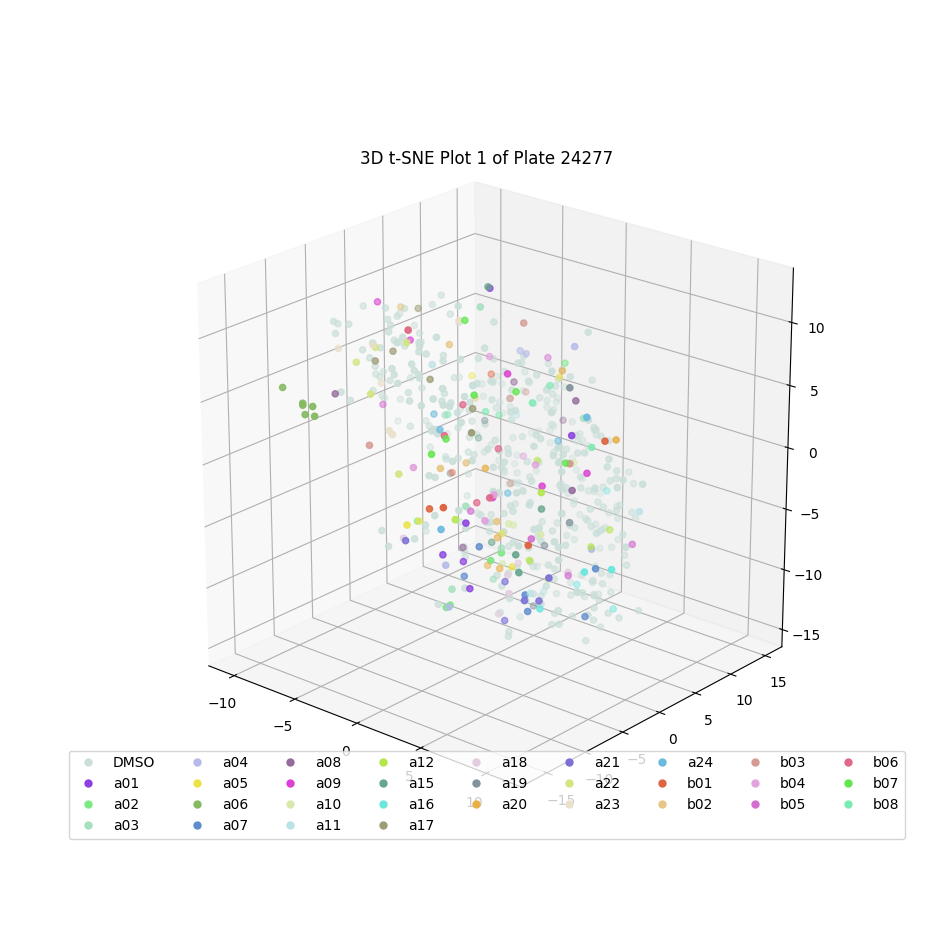

In [90]:
# Set up 3d environment
fig = plt.figure(figsize=(9.5, 9.5))
ax = fig.add_subplot(111, projection='3d')

# Plot the dots from JSON file parsed in R
ax.scatter(sub_data['x'], sub_data['y'], sub_data['z'], c=sub_data['color'])

# Add a legend
color_maps = dict(zip(map(lambda x: x.split('_')[1], sub_data['label']), sub_data['color']))
legend_elements = []
for l in color_maps:
    legend_elements.append(Line2D([], [], marker='o', color=color_maps[l],
                                  label=l, markersize=5, linestyle='None'))
plt.title("3D t-SNE Plot {} of Plate {}".format(1, 24277))
ax.legend(handles=legend_elements, loc='lower center', fancybox=True, ncol=9)
plt.show()

## 5. Hierarchical Clustering

Instead of projecting feature dimension to 3D or 2D, we can use try hierarchical clustering. There are many distance functions and linkage methods we can choose from.

I found `cosine` metric and `average` gives some interesting results.

In [8]:
def generate_data(input_dir):
    """
    Generate x and labels for tsne_reduction.
    """

    features = []
    labels = []
    for sub in [f.path for f in os.scandir(input_dir)]:
        plate = re.sub(r'^(\d*)_.*$', r'\1', os.path.basename(sub))
        for npz in glob(join(sub, '*.npz')):
            loaded_npz = np.load(npz)
            features.append(loaded_npz['feature'])
            labels.append('{}_{}'.format(
                plate,
                loaded_npz['cpd'].tolist()
            ))

    # Concatenate the features into size (num_sample, num_feature)
    features = np.vstack(features)
    return features, labels

In [9]:
# Test clustering in plate 24277
x, labels = generate_data("/Users/JayWong/Programs/gitter_lab/result_buffer/features_24277")
agg = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average')
agg.fit(x)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x10ea6f950>)

<IPython.core.display.Javascript object>


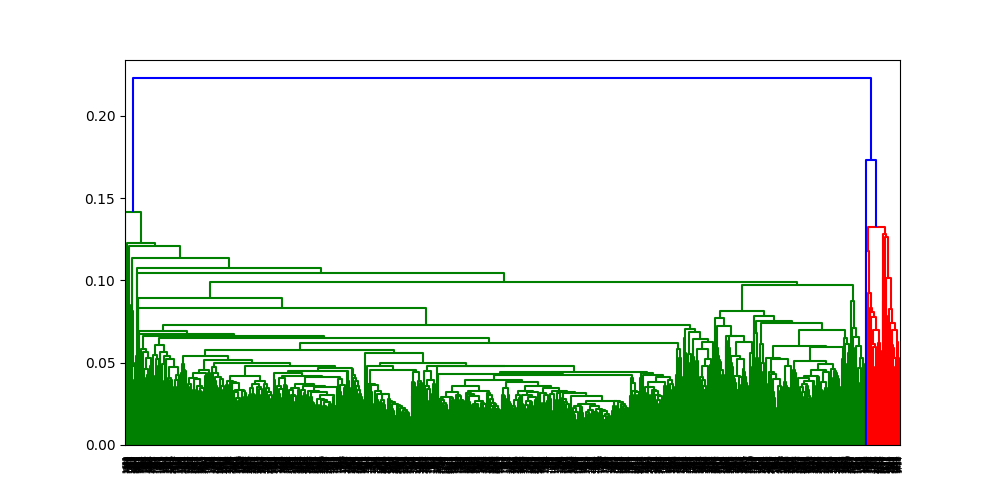

In [19]:
cluster = linkage(x, method='average', metric='cosine')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(cluster)
plt.show()

In [12]:
cluster = []
for i in range(len(agg.labels_)):
    if agg.labels_[i] == 0:
        cluster.append(labels[i])

# Get the well names in the smaller cluster
print(set(cluster))

{'24277_j10', '24277_f13', '24277_l11', '24277_o14', '24277_n22', '24277_m23', '24277_c08', '24277_m07', '24277_m20', '24277_a06', '24277_k19', '24277_i16', '24277_m16', '24277_d13', '24277_c01', '24277_c02', '24277_i09', '24277_p13', '24277_n18', '24277_h08', '24277_k11', '24277_j23', '24277_l06', '24277_p20', '24277_d02', '24277_o10', '24277_o24'}


Lets see if these compounds match those clustered compounds in our UMAP visualization.

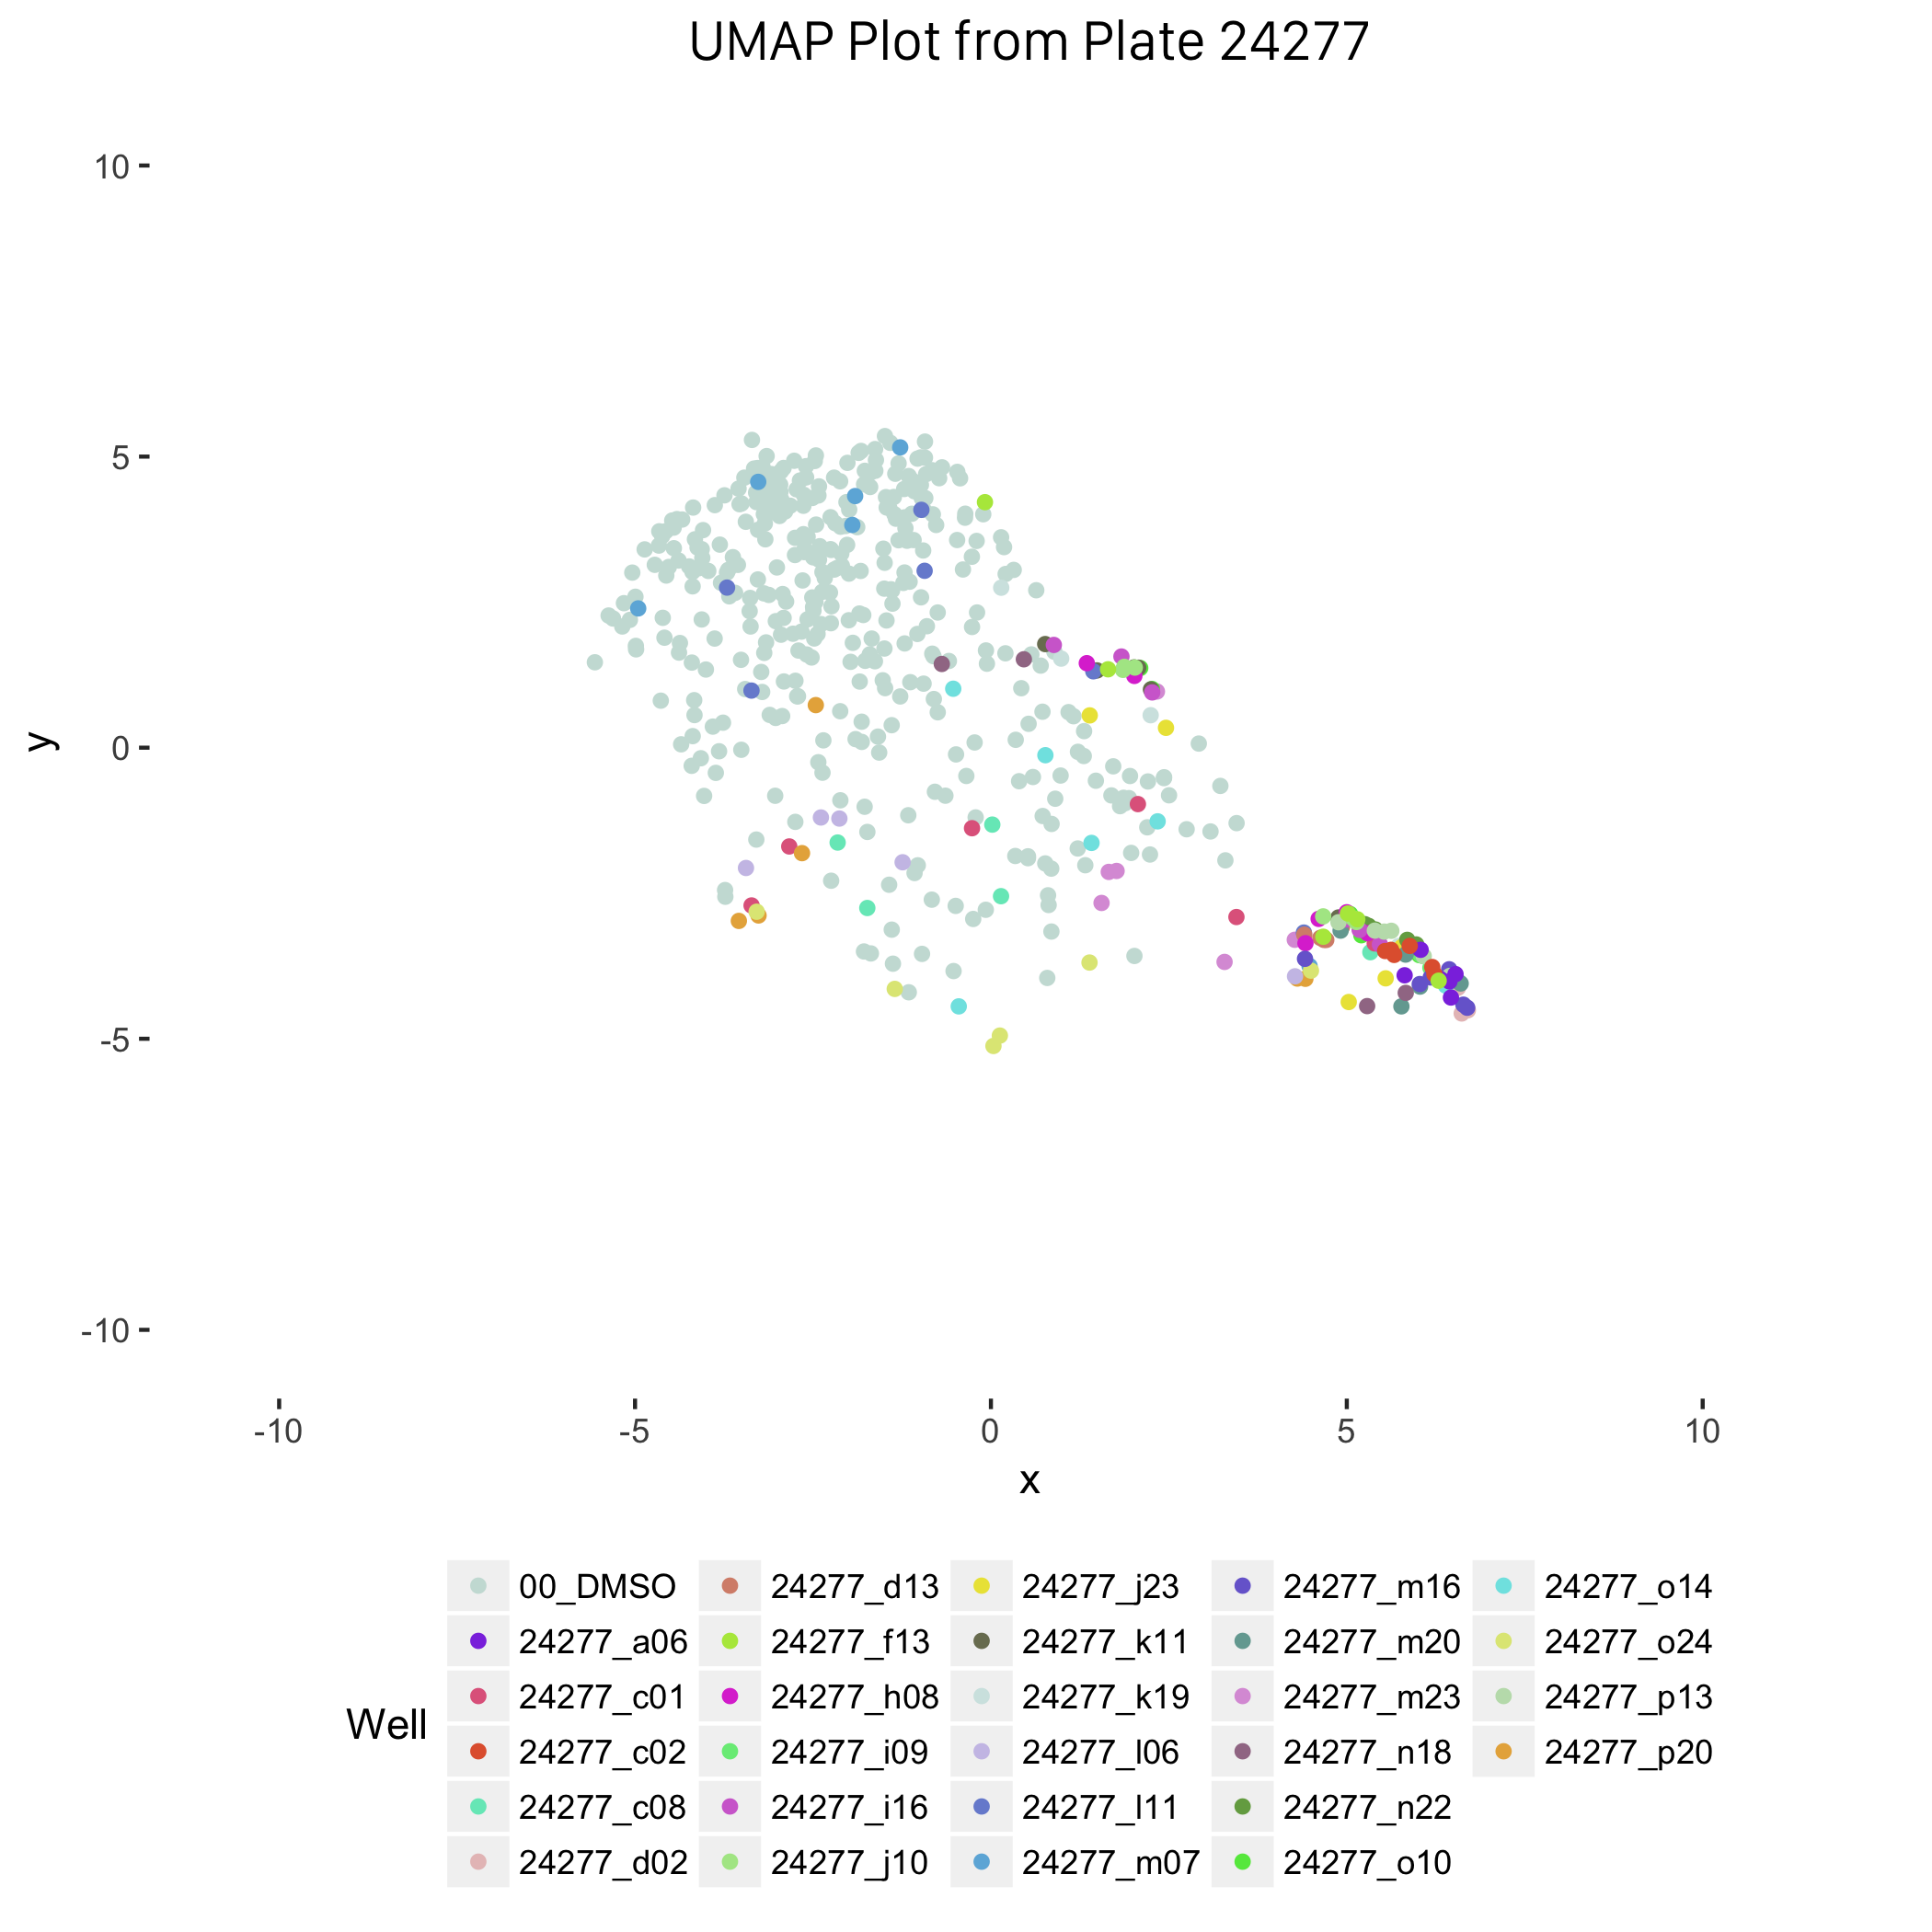

### 5.1. Comments:

1. The hierarchical clustering catches the same cluster as seen in t-SNE and UMAP.
2. Because I plot the 6 plates if one of them is in the minority cluster, there are some images mixed in the DMSO cluster.
3. We can test the cover rate of this method and t-SNE and UMAP, so we might be able to replace them. Hierarchical clustering gives us more information.